#IMDB Movie Rating Prediction



## EDA & Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [ ]:
import kagglehub
import os

# Download the dataset and get the path to the directory
path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

# List all files in the directory to find the CSV file
files = os.listdir(path)
print("Files in dataset:", files)

csv_file = next((f for f in files if "movies" in f and f.endswith(".csv")), None)

if csv_file:
    full_path = os.path.join(path, csv_file)
    df = pd.read_csv(full_path)
    print("Data preview:")
    print(df.head())
else:
    print("CSV file not found in the downloaded dataset.")


Files in dataset: ['TMDB_all_movies.csv']
Data preview:
   id                             title  vote_average  vote_count    status  \
0   2                             Ariel           7.1       335.0  Released   
1   3               Shadows in Paradise           7.3       369.0  Released   
2   5                        Four Rooms           5.8      2628.0  Released   
3   6                    Judgment Night           6.5       331.0  Released   
4   8  Life in Loops (A Megacities RMX)           7.5        27.0  Released   

  release_date     revenue  runtime      budget    imdb_id  ...  \
0   1988-10-21         0.0     73.0         0.0  tt0094675  ...   
1   1986-10-17         0.0     74.0         0.0  tt0092149  ...   
2   1995-12-09   4257354.0     98.0   4000000.0  tt0113101  ...   
3   1993-10-15  12136938.0    109.0  21000000.0  tt0107286  ...   
4   2006-01-01         0.0     80.0     42000.0  tt0825671  ...   

                         spoken_languages  \
0                    

In [ ]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (1023630, 28)


In [ ]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023630 entries, 0 to 1023629
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1023630 non-null  int64  
 1   title                    1023618 non-null  object 
 2   vote_average             1023628 non-null  float64
 3   vote_count               1023628 non-null  float64
 4   status                   1023628 non-null  object 
 5   release_date             909787 non-null   object 
 6   revenue                  1023628 non-null  float64
 7   runtime                  1023628 non-null  float64
 8   budget                   1023628 non-null  float64
 9   imdb_id                  592967 non-null   object 
 10  original_language        1023628 non-null  object 
 11  original_title           1023618 non-null  object 
 12  overview                 842789 non-null   object 
 13  popularity               102

### There are several columns that are not meaningful for our analysis:

1. **id** and **imdb_id** contain only identifiers
2. **overview** has summary of the movie's plot which is long text data
3. **poster_path** has link to movie's poster



In [ ]:
df = df.drop(columns=['id', 'imdb_id', 'overview', 'poster_path'])

In [ ]:
print(f'Shape of the dataset after dropping: {df.shape}')

Shape of the dataset after dropping: (1023630, 24)


In [ ]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                          12
vote_average                    2
vote_count                      2
status                          2
release_date               113843
revenue                         2
runtime                         2
budget                          2
original_language               2
original_title                 12
popularity                      2
tagline                    871452
genres                     296751
production_companies       550952
production_countries       404503
spoken_languages           392745
cast                       340204
director                   184508
director_of_photography    777625
writers                    527422
producers                  697584
music_composer             923777
imdb_rating                592762
imdb_votes                 592762
dtype: int64


### We will drop the rows with missing **imdb_rating**, which is our target for this project

In [ ]:
rows_before = df.shape[0]
df = df.dropna(subset=['imdb_rating'])
rows_after = df.shape[0]
print(f'Shape of the data after removing NA: {df.shape}')
print(f'Number of rows dropped: {rows_before - rows_after}')

Shape of the data after removing NA: (430868, 24)
Number of rows dropped: 592762


In [ ]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                           0
vote_average                    0
vote_count                      0
status                          0
release_date                 8259
revenue                         0
runtime                         0
budget                          0
original_language               0
original_title                  0
popularity                      0
tagline                    337789
genres                      54260
production_companies       155429
production_countries        96013
spoken_languages            93591
cast                        63449
director                    27073
director_of_photography    268680
writers                    130559
producers                  227669
music_composer             347009
imdb_rating                     0
imdb_votes                      0
dtype: int64


### We will also remove the rows with missing release_date since it only contains a small portion of data.

In [ ]:
df = df.dropna(subset=['release_date'])
print(f'Shape of the data after removing NA: {df.shape}')

Shape of the data after removing NA: (422609, 24)


In [ ]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 422609 entries, 0 to 1023584
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   title                    422609 non-null  object 
 1   vote_average             422609 non-null  float64
 2   vote_count               422609 non-null  float64
 3   status                   422609 non-null  object 
 4   release_date             422609 non-null  object 
 5   revenue                  422609 non-null  float64
 6   runtime                  422609 non-null  float64
 7   budget                   422609 non-null  float64
 8   original_language        422609 non-null  object 
 9   original_title           422609 non-null  object 
 10  popularity               422609 non-null  float64
 11  tagline                  91824 non-null   object 
 12  genres                   374206 non-null  object 
 13  production_companies     274652 non-null  object 

## Target column

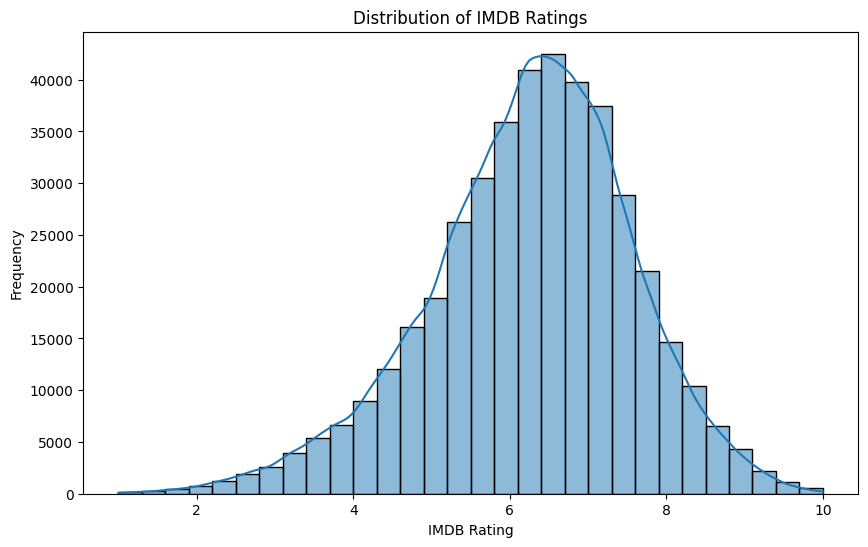

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['imdb_rating'], bins=30, kde=True)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

## Input variables
### vote_count & vote_average

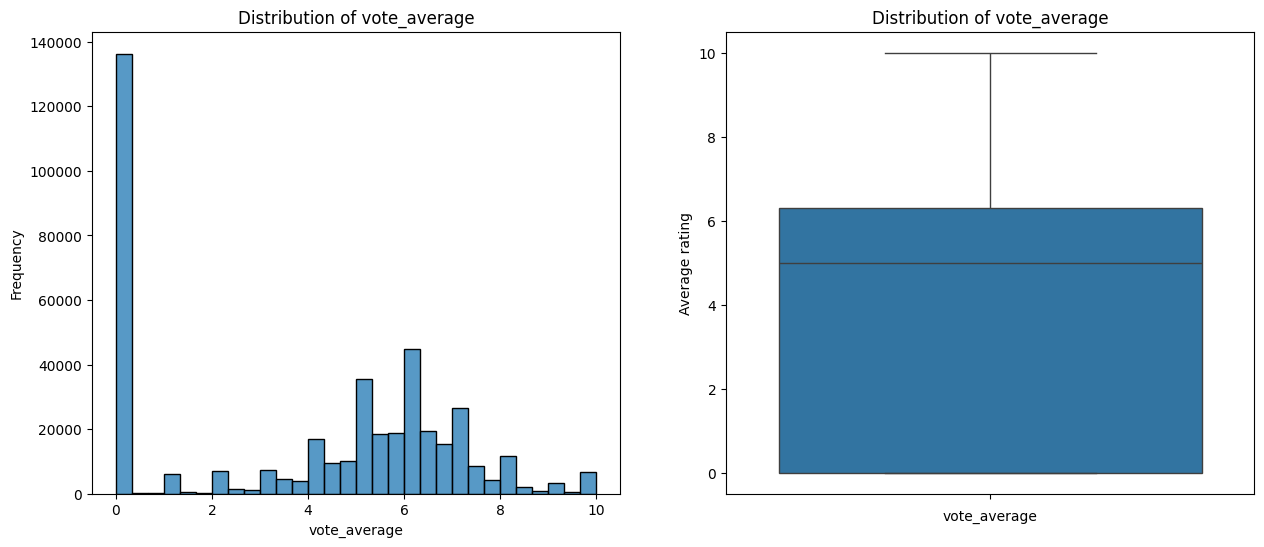

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

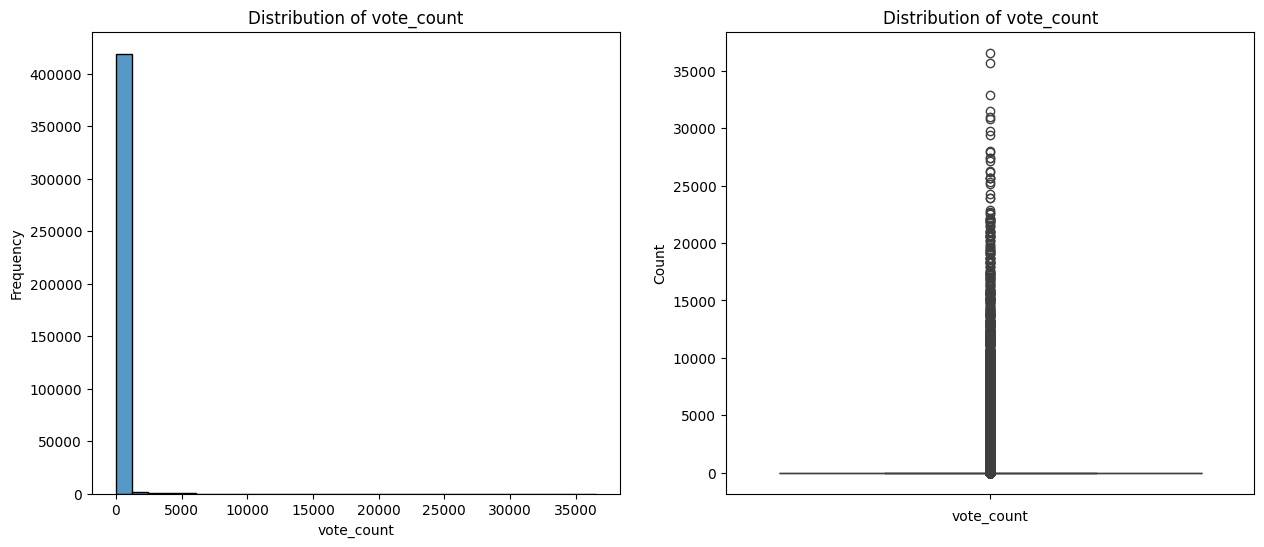

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

This is a highly skewed graph. It is not the result of any weird outliers, but the result of having too many movies with a every small number of vote_count and vote_average of zero.\
Let's see their distributions putting together.

Text(0.5, 1.0, 'Scatterplot of vote_average vs vote_count')

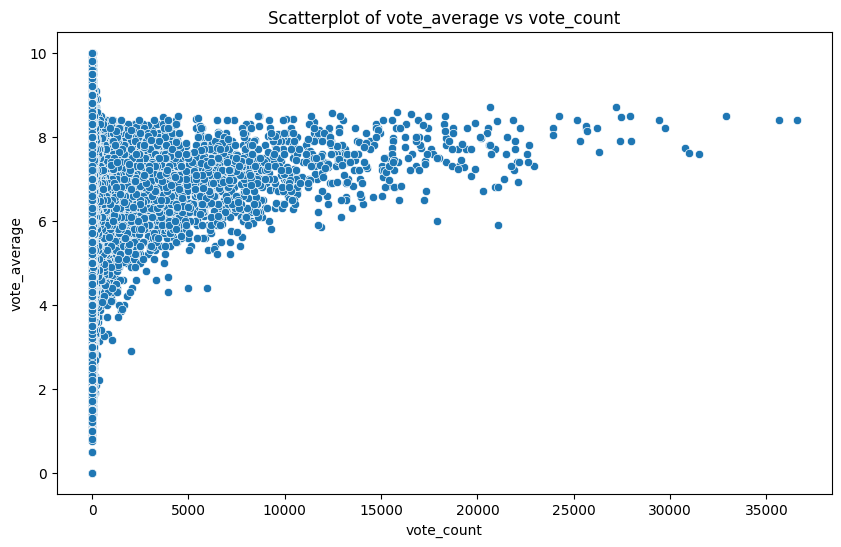

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='vote_average', data=df)
plt.title('Scatterplot of vote_average vs vote_count')

Now we will try to check the distribution without movies with zero votes.

In [ ]:
vote_df = df[['vote_average', 'vote_count']]
rows_before = vote_df.shape[0]
vote_df = vote_df[vote_df['vote_count'] > 0]
rows_after = vote_df.shape[0]
print(f'Number of movies with zero votes: {rows_before - rows_after}')

Number of movies with zero votes: 136136


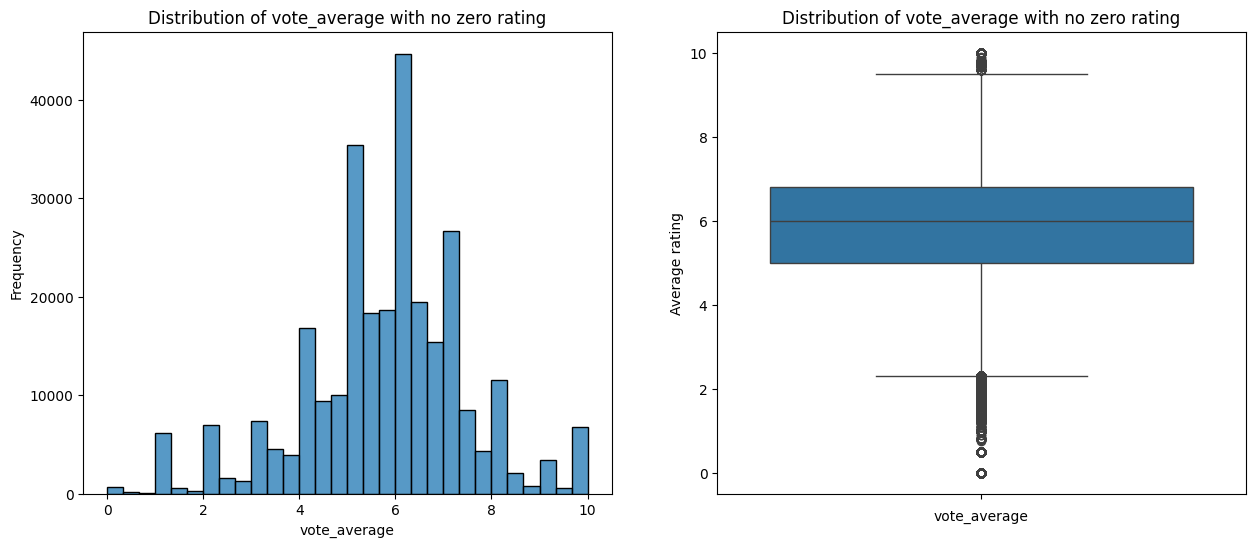

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average with no zero rating')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average with no zero rating')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

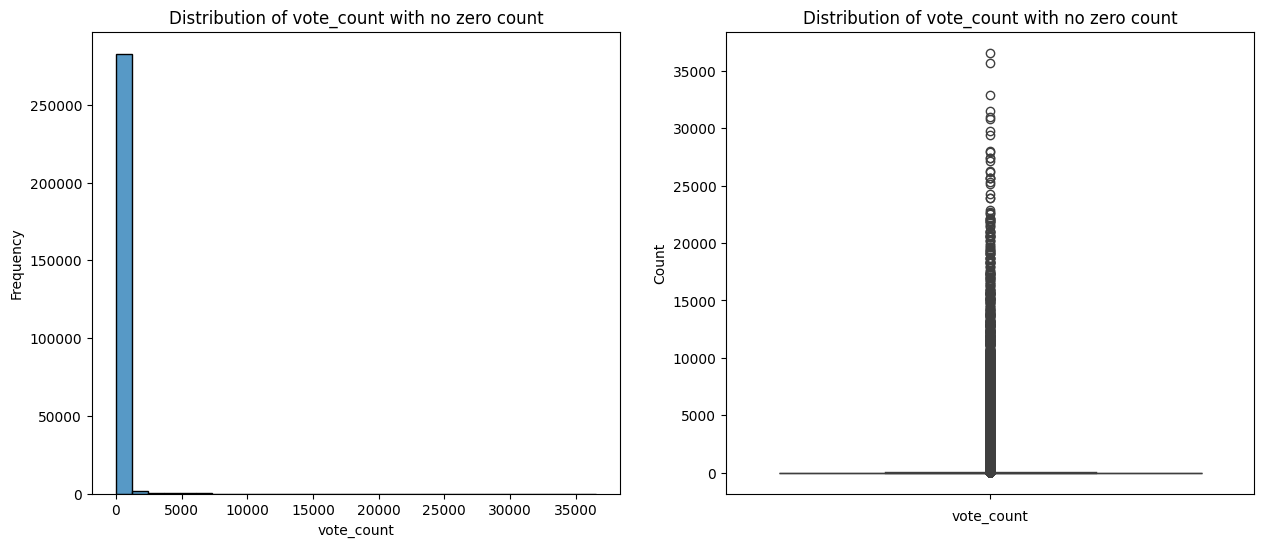

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count with no zero count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count with no zero count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

The distribution of vote_count is still highly skewed since there is a lot of movies with only a small number of votes.

### Status

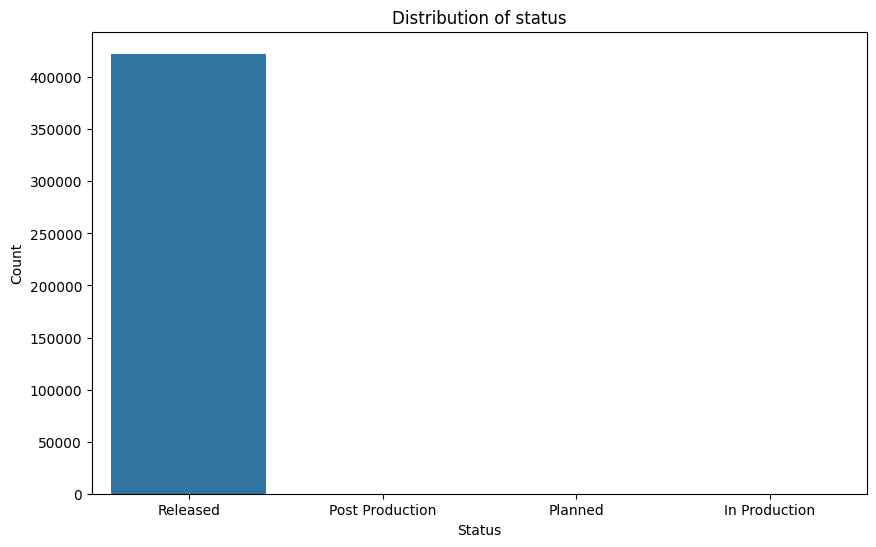

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['status'])
plt.title('Distribution of status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [ ]:
df['status'].value_counts()

,count
status,
Released,422554
Post Production,31
In Production,18
Planned,6


## release_date

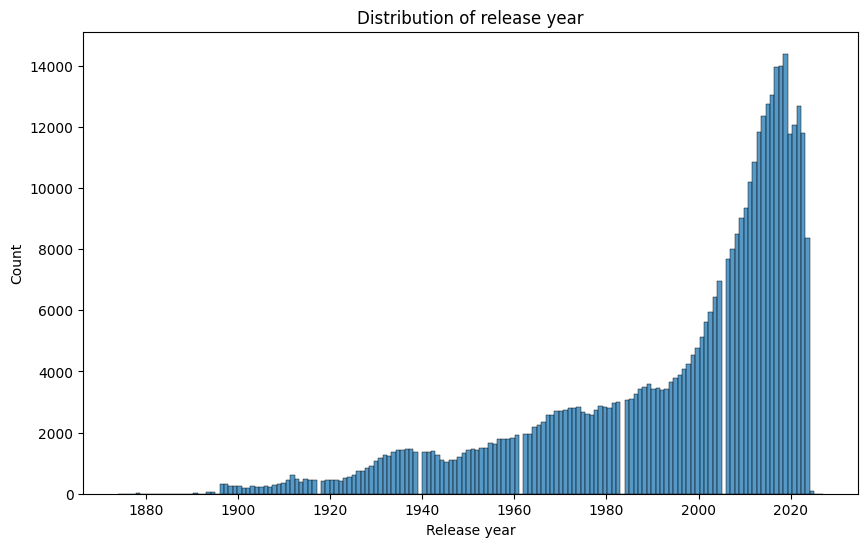

In [ ]:
dates = pd.to_datetime(df['release_date'])
plt.figure(figsize=(10, 6))
sns.histplot(dates.dt.year)
plt.title('Distribution of release year')
plt.xlabel('Release year')
plt.ylabel('Count')
plt.show()

## revenue




In [ ]:
df['revenue'].value_counts(ascending=False)

,count
revenue,
0.0,403470
100000.0,91
1000000.0,80
2000000.0,77
10000.0,67
...,...
33187.0,1
57696.0,1
858591.0,1


Since most of the movies does not have any revenue, it will be another skewed distribution. We will get rid of all the zeros and display the distribution of rest of the data.

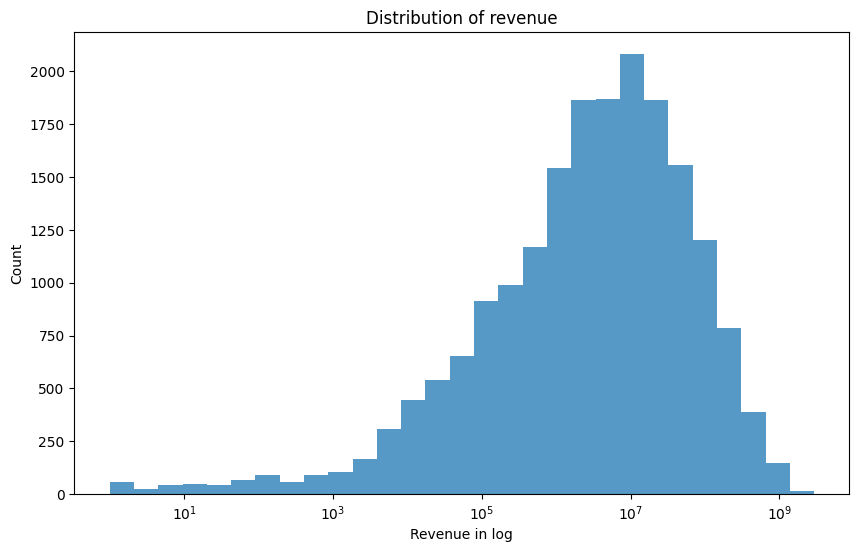

In [ ]:
r = df[df['revenue']>0]['revenue']
min_val = r.min()
max_val = r.max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), 30)

plt.figure(figsize=(10, 6))
sns.histplot(r, bins=bins)
plt.title('Distribution of revenue')
plt.xlabel('Revenue in log')
plt.ylabel('Count')
plt.xscale('log')
plt.show()

## Sampling & Encoding

### Handling release_date and original_title

In [ ]:
df['original_title_match'] = df['original_title'] == df['title']
df.drop(columns=['original_title'], inplace=True)

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

def get_decade(year):
    if pd.isna(year):
        return None
    return f"{(year // 10) * 10}s"

df['decade'] = df['release_year'].apply(get_decade)
df_decade_dummies = pd.get_dummies(df['decade'], prefix='decade')
df = pd.concat([df, df_decade_dummies], axis=1)

### Text Vectorization

In [ ]:
vectorize_cols = ['title', 'tagline', 'cast', 'director',
                  'director_of_photography', 'writers',
                  'producers', 'music_composer']

# vectorize_cols = ['title']

vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

for col in tqdm(vectorize_cols):
    df[col] = df[col].fillna('')
    df[col] = df[col].apply(lambda x: ' '.join([name.strip().replace(' ', '_') for name in x.split(',')]))


    tfidf_matrix = vectorizer.fit_transform(df[col])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat([df, tfidf_df], axis=1)

print(df.head())

100%|██████████| 8/8 [00:55<00:00,  6.90s/it]

                              title  vote_average  vote_count    status  \
0                             Ariel           7.1       335.0  Released   
1               Shadows_in_Paradise           7.3       369.0  Released   
2                        Four_Rooms           5.8      2628.0  Released   
3                    Judgment_Night           6.5       331.0  Released   
4  Life_in_Loops_(A_Megacities_RMX)           7.5        27.0  Released   

  release_date     revenue  runtime      budget original_language  popularity  \
0   1988-10-21         0.0     73.0         0.0                fi      11.915   
1   1986-10-17         0.0     74.0         0.0                fi      16.287   
2   1995-12-09   4257354.0     98.0   4000000.0                en      21.312   
3   1993-10-15  12136938.0    109.0  21000000.0                en       8.924   
4   2006-01-01         0.0     80.0     42000.0                en       3.203   

   ... stelvio_cipriani thomas_newman victor_young vladimir_co

In [ ]:
print(df.shape)
print(df.columns)

(422609, 842)
Index(['title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'budget', 'original_language', 'popularity',
       ...
       'stelvio_cipriani', 'thomas_newman', 'victor_young', 'vladimir_cosma',
       'wang_fu', 'william_lava', 'williams', 'winston_sharples',
       'yuvan_shankar_raja', 'zdeněk_liška'],
      dtype='object', length=842)


### Random split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the validation set: {X_val.shape}')
print(f'Shape of the test set: {X_test.shape}')

Shape of the training set: (338087, 841)
Shape of the validation set: (42261, 841)
Shape of the test set: (42261, 841)


### Stratified split

In [ ]:
kbd = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='quantile')
y_bin = kbd.fit_transform(df[['imdb_rating']])
X_train_str, X_temp_str, y_train_str, y_temp_str = train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.2, random_state=42, stratify=y_bin)
y_temp_str = pd.DataFrame(y_temp_str, columns=['imdb_rating'])
y_test_bin = kbd.transform(y_temp_str)
X_val_str, X_test_str, y_val_str, y_test_str = train_test_split(X_temp_str, y_temp_str, test_size=0.5, random_state=42, stratify=y_test_bin)
print(f'Shape of the training set: {X_train_str.shape}')
print(f'Shape of the validation set: {X_val_str.shape}')
print(f'Shape of the test set: {X_test_str.shape}')

## Encoding

Numerical features

In [ ]:
# Random split
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("Random split:")
print(X_train[numerical_cols].head())
print("")

# Stratified split
numerical_cols_str = X_train_str.select_dtypes(include=['int64', 'float64']).columns
scaler_str = StandardScaler()
X_train_str[numerical_cols_str] = scaler_str.fit_transform(X_train_str[numerical_cols_str])
X_val_str[numerical_cols_str] = scaler_str.transform(X_val_str[numerical_cols_str])
X_test_str[numerical_cols_str] = scaler_str.transform(X_test_str[numerical_cols_str])
print("Stratified split:")
print(X_train_str[numerical_cols].head())

Categorical features

In [ ]:
categorical_vars = df.select_dtypes(include=['object', 'category']).columns
print("Categorical variables in the DataFrame:")
print(categorical_vars)

Categorical variables in the DataFrame:
Index(['title', 'status', 'release_date', 'original_language',
       'original_title', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'cast', 'director',
       'director_of_photography', 'writers', 'producers', 'music_composer'],
      dtype='object')


In [ ]:
finite_categories = ['status', 'original_language', 'genres', 'production_companies', 'production_countries', 'spoken_languages']
for col in finite_categories:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())


Column: status
Unique values: ['Released' 'Post Production' 'Planned' 'In Production']

Column: original_language
Unique values: ['fi' 'en' 'de' 'he' 'es' 'zh' 'ja' 'da' 'fr' 'ko' 'pl' 'sv' 'it' 'bs'
 'hi' 'ru' 'no' 'pt' 'nl' 'el' 'cs' 'bn' 'cn' 'tn' 'sr' 'mn' 'et' 'is'
 'ca' 'ro' 'hu' 'se' 'ps' 'th' 'xx' 'tr' 'sh' 'fa' 'ht' 'bg' 'zu' 'ar'
 'mr' 'ku' 'bo' 'ta' 'tl' 'kk' 'hr' 'id' 'am' 'lt' 'iu' 'pa' 'te' 'sl'
 'vi' 'ml' 'mk' 'sk' 'af' 'ur' 'km' 'nb' 'ms' 'hy' 'uk' 'ka' 'la' 'kn'
 'dz' 'ga' 'eu' 'bm' 'sq' 'gl' 'mo' 'si' 'rw' 'ky' 'eo' 'xh' 'az' 'jv'
 'tg' 'ff' 'lv' 'oc' 'wo' 'ik' 'uz' 'lo' 'ks' 'sm' 'gd' 'cy' 'ln' 'sn'
 'yi' 'tk' 'ab' 'mt' 'sw' 'kl' 'ne' 'fo' 'so' 've' 'lb' 'sa' 'co' 'yo'
 'fy' 'gu' 'sc' 'ig' 'ay' 'mg' 'gn' 'qu' 'cr' 'cv' 'mh' 'mi' 'my' 'to'
 'dv' 'tw' 'or' 'st' 'li' 'as' 'ha' 'ug' 'ak' 'nn' 'be' 'ti' 'ny' 'ty'
 'ss' 'om' 'tt' 'ce' 'rm' 'os' 'nv' 'gv' 'sd' 'lg' 'ba' 'su' 'kg' 'kw'
 'nd' 'sg']

Column: genres
Unique values: ['Comedy, Drama, Romance, Crime' 'Comedy, Dram

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
status_encoded = one_hot_encoder.fit_transform(df[['status']])

status_encoded_df = pd.DataFrame(status_encoded, columns=one_hot_encoder.get_feature_names_out(['status']), index=df.index)
df = pd.concat([df, status_encoded_df], axis=1)

target_encode_cols = ['original_language', 'production_companies', 'production_countries', 'spoken_languages', 'genres']

target_col = 'imdb_rating'

for col in target_encode_cols:
    target_mean = df.groupby(col)[target_col].mean()
    df[f"{col}_target_encoded"] = df[col].map(target_mean)

df.drop(columns=target_encode_cols, inplace=True)

print(df.head())

                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows in Paradise      1.123579    0.556916  Released   
2                        Four Rooms      0.628477    4.568549  Released   
3                    Judgment Night      0.859525    0.489284  Released   
4  Life in Loops (A Megacities RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  \
0   1988-10-21 -0.066906  0.072079 -0.095732   
1   1986-10-17 -0.066906  0.088067 -0.095732   
2   1995-12-09  0.091338  0.471778  0.456426   
3   1993-10-15  0.384219  0.647645  2.803097   
4   2006-01-01 -0.066906  0.183995 -0.089935   

                     original_title  popularity  ... imdb_rating imdb_votes  \
0                             Ariel    0.558098  ...    0.885384   0.185339   
1              Varjoja paratiisissa    0.840113  ...    0.961638   0.146244   
2                      

## Dimension Reduction:

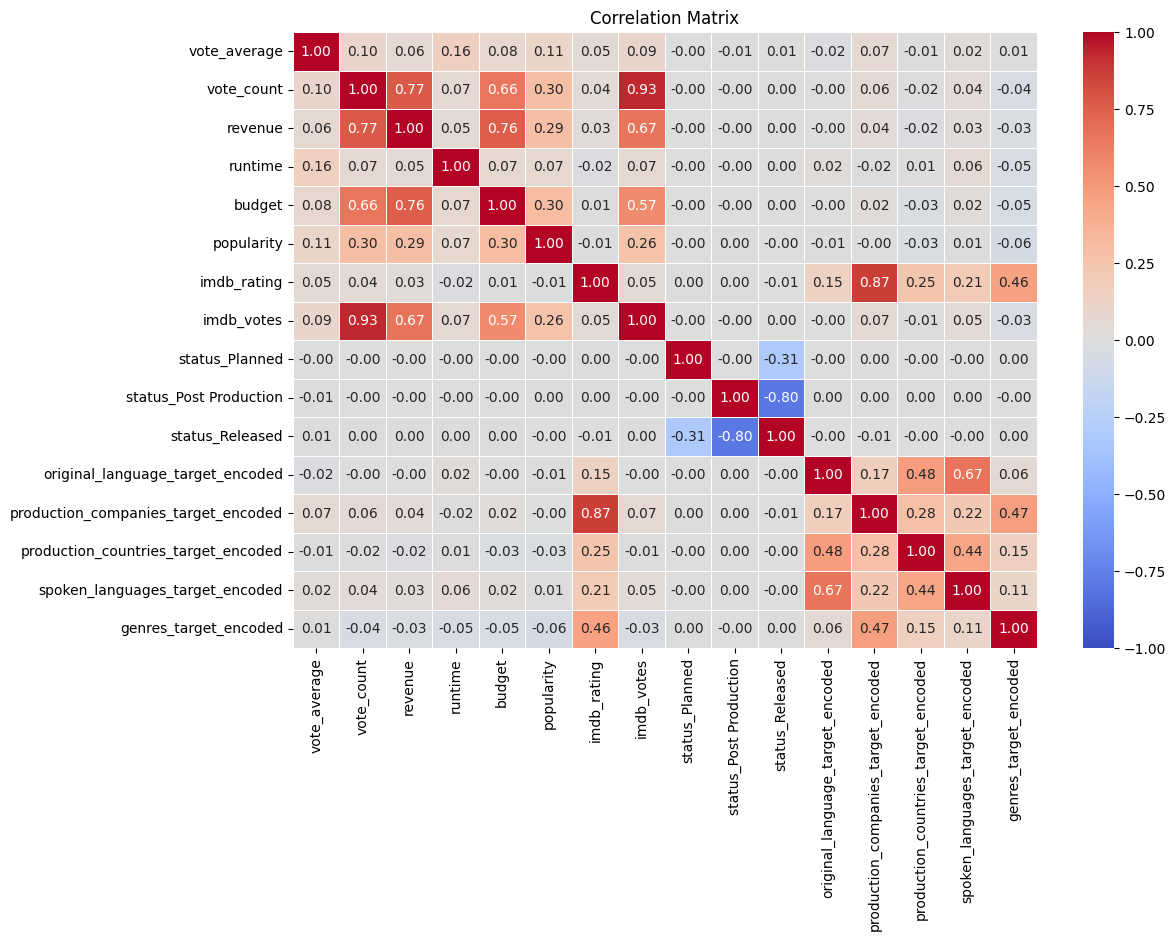

Dropped columns: {'production_companies_target_encoded', 'imdb_votes'}
                              title  vote_average  vote_count    status  \
0                             Ariel      1.057565    0.496403  Released   
1               Shadows in Paradise      1.123579    0.556916  Released   
2                        Four Rooms      0.628477    4.568549  Released   
3                    Judgment Night      0.859525    0.489284  Released   
4  Life in Loops (A Megacities RMX)      1.189593   -0.051770  Released   

  release_date   revenue   runtime    budget  \
0   1988-10-21 -0.066906  0.072079 -0.095732   
1   1986-10-17 -0.066906  0.088067 -0.095732   
2   1995-12-09  0.091338  0.471778  0.456426   
3   1993-10-15  0.384219  0.647645  2.803097   
4   2006-01-01 -0.066906  0.183995 -0.089935   

                     original_title  popularity  ...  \
0                             Ariel    0.558098  ...   
1              Varjoja paratiisissa    0.840113  ...   
2                    

In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df[numerical_cols]
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


cols_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            cols_to_drop.add(colname)

df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")
print(df.head())
